# EPRL self energy

Notebook for the analysis of EPRL self energy

## Setup

In [1]:
using CSV
using DataFrames
using HalfIntegers, JLD2, Distributions, Random
using LaTeXStrings

In [2]:
using Statistics
using StatsBase
using StatsPlots

In [3]:
# this allows to save images as eps using the "savefig" function, but it changes the plot style as well
# pyplot()

To save images in eps, we run *imagemagick* via shell command

In [4]:
pgfplotsx()
theme(:default)
default(
    markerstrokewidth = 0,
    markerstrokealpha = 0,
    grid = :true,
    gridlinewidth = 0.5,
    fontfamily="Computer Modern",
    framestyle=:box,
    size=(800,300),
    margin=5Plots.mm
)
scalefontsizes(1.7)

# Decide how many Monte Carlo samples we take

**First, we work with fixed $\Delta l = 10$, dealing with the extrapolation later on.** 

We compare the results of MC sampling with $N_{mc}=1\,000$, $N_{mc}=10\,000$, $N_{mc}=100\,000$ samples. We compare with the exact result for the amplitude. 

We estimate the value of the Layers averaging over 20 trials and the error with the standard deviation. Then we sum the average value of the layers and we sum variances

In [5]:
BASE_DATA_DIRECTORY = "../../data";

function get_data(Nmc, Dl, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(Nmc)/EPRL/immirzi_0.1/Dl_$(Dl)/weight_1.0/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

get_data (generic function with 1 method)

In [5]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(1000,10, trial).amp[id] - get_data(1000,10, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc1K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc1K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

relative_error_Nmc1K = error_Nmc1K./amplitude_Nmc1K;

In [6]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(10000,10, trial).amp[id] - get_data(10000,10, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc10K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc10K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

relative_error_Nmc10K = error_Nmc10K./amplitude_Nmc10K;

In [7]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(100000,10, trial).amp[id] - get_data(100000,10, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc100K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc100K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

relative_error_Nmc100K = error_Nmc100K./amplitude_Nmc100K;

plot1 = Plot{Plots.PGFPlotsXBackend() n=3}


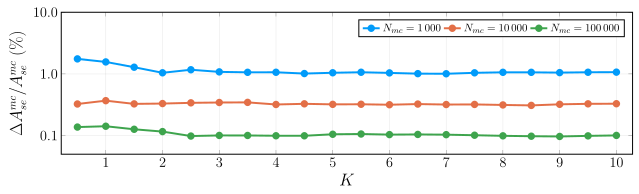

In [9]:
plot1 = plot(0.5:0.5:10,
               [100*relative_error_Nmc1K, 100*relative_error_Nmc10K,100*relative_error_Nmc100K],
               label = [L"$N_{mc}=1\,000$" L"$N_{mc}=10\,000$" L"$N_{mc}=100\,000$"],
               yscale=:log10,
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               size = (900, 300),
               ylim = (0.05,10),
               ylabel = L"\Delta A_{se}^{mc}/A_{se}^{mc} \ (\%)",
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               legend_column = -1,
               legend = (0.52, 0.95),
               legendfontsize=11,
               yguidefontsize=16,
               xguidefontsize=16,
               )
#title!(plot1, "Monte Carlo error")
savefig(plot1,"./plots/EPRL/self_energy/SE_EPRL_relative_errors.svg")
#savefig(plot1,"./plots/BF/self_energy/relative_errors.pdf")

@show plot1


In [18]:
function get_self_energy_exact(Dl)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/exact/EPRL/immirzi_0.1/Dl_$(Dl)/ampls_cutoff_10_ib_0.0.csv",
        ),
    )
end
exact_amplitude = get_self_energy_exact(10).amp[2:end];


relative_Nmc100K  = (amplitude_Nmc100K ./exact_amplitude .-1);
error_relative_Nmc100K = error_Nmc100K ./exact_amplitude;


plot2 = Plot{Plots.PGFPlotsXBackend() n=1}


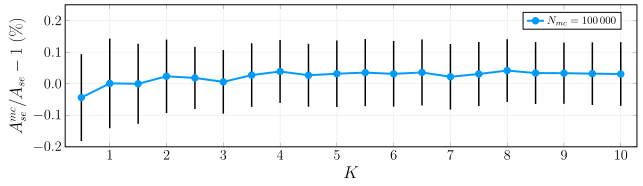

In [24]:
plot2 = plot(0.5:0.5:10,
               100 .* relative_Nmc100K,
               label =  L"$N_{mc}=100\,000$",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               ylim = (-0.20, 0.25),
               legend = (0.80,0.95),
               size = (900, 300),
               ylabel = L"A_{se}^{mc}/A_{se} -1 \ (\%)",
               xlabel = L"K",
               yerror= 100 .* error_relative_Nmc100K,
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               margin=5Plots.mm,
               legendfontsize=11,
               yguidefontsize=16,
               xguidefontsize=16,
               )

#title!(plot2, "Monte Carlo error compared with exact amplitude")
savefig(plot2,"./plots/EPRL/self_energy/SE_EPRL_MC_with_exact_with_error_bars.svg")
#savefig(plot2,"./plots/BF/self_energy/with_error_bars.pdf")

@show plot2

In [9]:
#run(`convert -density 300 -trim ./plots/BF/self_energy/with_error_bars.svg -quality 100 ./plots/BF/self_energy/with_error_bars.eps`)

Even in loglog scale the exact and the MC are the one on top of the other

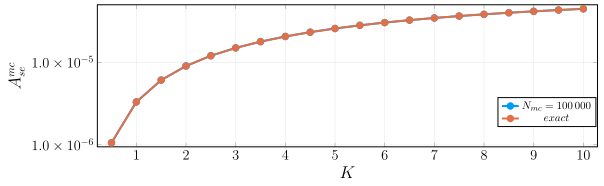

In [12]:
plot3 = plot(0.5:0.5:10,
               [amplitude_Nmc100K,exact_amplitude],
            #   label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
               label =  [L"$N_{mc}=100\,000$" L"exact"],
               #title = ["Comparison with exact"],
               yscale=:log10,
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.80,0.35),
               ylabel = L"A_{se}^{mc}",
               xlabel = L"K",
               yerror= error_Nmc100K,
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               grid=true,
               margin=5Plots.mm,
               legendfontsize=11,
               yguidefontsize=16,
               xguidefontsize=16,
               )

# Extrapolation

We now deal with the extrapolation. We use the _numerically stable_ version:

$$
W_{\Delta l} (K) = W(K, \Delta l) - \frac{(W(K, \Delta l) - W(K, \Delta l-1))^2}{W(K, \Delta l) - 2W(K, \Delta l-1) + W(K, \Delta l-2)}
$$

In [6]:
function extrapolate(dataDl,dataDlm1,dataDlm2)
    dataDl - (dataDl - dataDlm1)^2/(dataDl - 2*dataDlm1 + dataDlm2);
end

extrapolate (generic function with 1 method)

Let's extrapolate each trial *independently*. For each trial we sum all layers and then we extrapolate. 

We repeat this for all trials, averaging the final results.

In [7]:
test_ampl_DL10_Nmc1K = DataFrame()
for trial in 1:20
    test_ampl_DL10_Nmc1K[!,"$(trial)"]=[get_data(1000,10, trial).amp[id] for id in 2:21]
end

test_ampl_DL9_Nmc1K = DataFrame()
for trial in 1:20
    test_ampl_DL9_Nmc1K[!,"$(trial)"]=[get_data(1000,9, trial).amp[id] for id in 2:21]
end

test_ampl_DL8_Nmc1K = DataFrame()
for trial in 1:20
    test_ampl_DL8_Nmc1K[!,"$(trial)"]=[get_data(1000,8, trial).amp[id] for id in 2:21]
end

test_ampl_extrapolation_Nmc1K = DataFrame()
for trial in 1:20
    test_ampl_extrapolation_Nmc1K[!,"$(trial)"]= extrapolate.(test_ampl_DL10_Nmc1K[!,"$(trial)"],test_ampl_DL9_Nmc1K[!,"$(trial)"],test_ampl_DL8_Nmc1K[!,"$(trial)"])
end

avg_ampl_extrapolation_Nmc1K =  [mean(row) for row in eachrow(test_ampl_extrapolation_Nmc1K)]
var_ampl_extrapolation_Nmc1K =  [var(row) for row in eachrow(test_ampl_extrapolation_Nmc1K)];

error_Nmc1K_extrap = sqrt.([var_ampl_extrapolation_Nmc1K[id] for id in 1:20]);

relative_error_Nmc1K_extrap = error_Nmc1K_extrap./avg_ampl_extrapolation_Nmc1K;

In [8]:
test_ampl_DL10_Nmc10K = DataFrame()
for trial in 1:20
    test_ampl_DL10_Nmc10K[!,"$(trial)"]=[get_data(10000,10, trial).amp[id] for id in 2:21]
end

test_ampl_DL9_Nmc10K = DataFrame()
for trial in 1:20
    test_ampl_DL9_Nmc10K[!,"$(trial)"]=[get_data(10000,9, trial).amp[id] for id in 2:21]
end

test_ampl_DL8_Nmc10K = DataFrame()
for trial in 1:20
    test_ampl_DL8_Nmc10K[!,"$(trial)"]=[get_data(10000,8, trial).amp[id] for id in 2:21]
end

test_ampl_extrapolation_Nmc10K = DataFrame()
for trial in 1:20
    test_ampl_extrapolation_Nmc10K[!,"$(trial)"]= extrapolate.(test_ampl_DL10_Nmc10K[!,"$(trial)"],test_ampl_DL9_Nmc10K[!,"$(trial)"],test_ampl_DL8_Nmc10K[!,"$(trial)"])
end

avg_ampl_extrapolation_Nmc10K =  [mean(row) for row in eachrow(test_ampl_extrapolation_Nmc10K)]
var_ampl_extrapolation_Nmc10K =  [var(row) for row in eachrow(test_ampl_extrapolation_Nmc10K)];

error_Nmc10K_extrap = sqrt.([var_ampl_extrapolation_Nmc10K[id] for id in 1:20]);

relative_error_Nmc10K_extrap = error_Nmc10K_extrap./avg_ampl_extrapolation_Nmc10K;

In [9]:
test_ampl_DL10_Nmc100K = DataFrame()
for trial in 1:20
    test_ampl_DL10_Nmc100K[!,"$(trial)"]=[get_data(100000,10, trial).amp[id] for id in 2:21]
end

test_ampl_DL9_Nmc100K = DataFrame()
for trial in 1:20
    test_ampl_DL9_Nmc100K[!,"$(trial)"]=[get_data(100000,9, trial).amp[id] for id in 2:21]
end

test_ampl_DL8_Nmc100K = DataFrame()
for trial in 1:20
    test_ampl_DL8_Nmc100K[!,"$(trial)"]=[get_data(100000,8, trial).amp[id] for id in 2:21]
end

test_ampl_extrapolation_Nmc100K = DataFrame()
for trial in 1:20
    test_ampl_extrapolation_Nmc100K[!,"$(trial)"]= extrapolate.(test_ampl_DL10_Nmc100K[!,"$(trial)"],test_ampl_DL9_Nmc100K[!,"$(trial)"],test_ampl_DL8_Nmc100K[!,"$(trial)"])
end

avg_ampl_extrapolation_Nmc100K =  [mean(row) for row in eachrow(test_ampl_extrapolation_Nmc100K)]
var_ampl_extrapolation_Nmc100K =  [var(row) for row in eachrow(test_ampl_extrapolation_Nmc100K)];

error_Nmc100K_extrap = sqrt.([var_ampl_extrapolation_Nmc100K[id] for id in 1:20]);

relative_error_Nmc100K_extrap = error_Nmc100K_extrap./avg_ampl_extrapolation_Nmc100K;

plot1 = Plot{Plots.PGFPlotsXBackend() n=3}


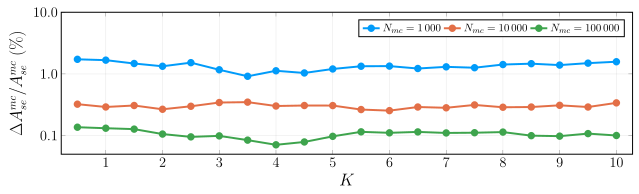

In [77]:
pgfplotsx()
plot1 = plot(0.5:0.5:10,
               [100*relative_error_Nmc1K_extrap, 100*relative_error_Nmc10K_extrap,100*relative_error_Nmc100K_extrap],
               label = [L"$N_{mc}=1\,000$" L"$N_{mc}=10\,000$" L"$N_{mc}=100\,000$"],
               yscale=:log10,
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               size = (900, 300),
               ylim = (0.05,10),
               ylabel = L"\Delta A_{se}^{mc}/A_{se}^{mc} \ (\%)",
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               legend_column = -1,
               legend = (0.52, 0.95),
               legendfontsize=11,
               yguidefontsize=16,
               xguidefontsize=16,
               )
#title!(plot1, "Monte Carlo error")
savefig(plot1,"./plots/EPRL/self_energy/SE_EPRL_extrapolations_relative_errors.svg")
#savefig(plot1,"./plots/BF/self_energy/relative_errors.pdf")

@show plot1

We infer that the *MC error* as function of cutoff is stable under extrapolation.

Let's now evaluate ratio between MC extrapolation and exact extrapolation

In [13]:
function get_self_energy_exact(Dl)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/exact/EPRL/immirzi_0.1/Dl_$(Dl)/ampls_cutoff_10_ib_0.0.csv",
        ),
    )
end
exact_amplitude_Dl_8 = get_self_energy_exact(8).amp[2:end];
exact_amplitude_Dl_9 = get_self_energy_exact(9).amp[2:end];
exact_amplitude_Dl_10 = get_self_energy_exact(10).amp[2:end];

exact_extrap_ampl = extrapolate.(exact_amplitude_Dl_10[:],exact_amplitude_Dl_9[:],exact_amplitude_Dl_8[:])

relative_Nmc100K  = (avg_ampl_extrapolation_Nmc100K ./exact_extrap_ampl .-1);
error_relative_Nmc100K = error_Nmc100K_extrap ./exact_extrap_ampl;

plot2 = Plot{Plots.PGFPlotsXBackend() n=1}


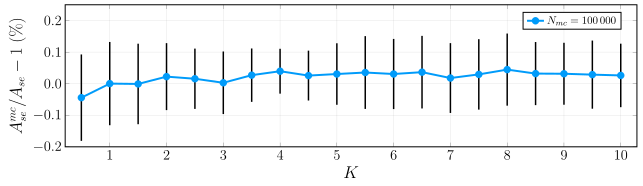

In [79]:
plot2 = plot(0.5:0.5:10,
               100 .* relative_Nmc100K,
               label =  L"$N_{mc}=100\,000$",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.80,0.95),
               size = (900, 300),
               ylim = (-0.20, 0.25),
               ylabel = L"A_{se}^{mc}/A_{se} -1 \ (\%)",
               xlabel = L"K",
               yerror= 100 .* error_relative_Nmc100K,
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               margin=5Plots.mm,
               legendfontsize=11,
               yguidefontsize=16,
               xguidefontsize=16,
               )

#title!(plot2, "Monte Carlo error compared with exact amplitude")
savefig(plot2,"./plots/EPRL/self_energy/SE_EPRL_extrapolations_MC_with_exact_with_error_bars.svg")
#savefig(plot2,"./plots/BF/self_energy/with_error_bars.pdf")

@show plot2

# Fitting the amplitude to find the scaling

We fit the amplitude as a function of the cutoff K using least squares fit. We use as a model the function:

$$ c_2K^{c_1} +  c_3 K^{c_1-1}$$

and we perform the fit using only the last 10-ish points. The error is computed automatically by the library. We use the 95% CI.

We first need to extrapolate the amplitude.

In [10]:
using LsqFit

In [14]:
@. model_two_terms(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [4.0,1.0, 1.0]
# We perform the Least Squares Fit considering just the values from K = 5 to 10 with steps of 1/2
fit_two_terms = curve_fit(model_two_terms, cutoffs[10:end], exact_extrap_ampl[10:end], c0)
@show fit_two_terms.param
@show margin_error(fit_two_terms, 0.05); 

fit_two_terms.param = [2.2481345380457194, -4.6060001515646335e-8, 4.571150456409095e-6]
margin_error(fit_two_terms, 0.05) = [0.015036262988911014, 6.93679102198667e-9, 7.543182398952941e-8]


The exponent seems to be quadratic, but the coefficient $c_2$ is 2 orders of magnitude smaller than $c_3$. I interpret this as spurious effect of the fit. 

Changing the model by keeping just the leading order:

$$ c_2K^{c_1} +  c_3 $$

the fit is way more linear, and the error is smaller, as shown below

In [15]:
@. model_one_term(K, c) = c[2] * K^c[1]+ c[3]

fit_one_term = curve_fit(model_one_term, cutoffs[10:end], exact_extrap_ampl[10:end], c0)
@show fit_one_term.param
@show margin_error(fit_one_term, 0.05); 

fit_one_term.param = [1.0909577602352185, 6.1862066369334795e-6, -3.475921205387331e-6]
margin_error(fit_one_term, 0.05) = [0.005128005850082332, 9.272024279551668e-8, 2.535504356121104e-7]


Useful visual check

plot2 = Plot{Plots.PGFPlotsXBackend() n=2}


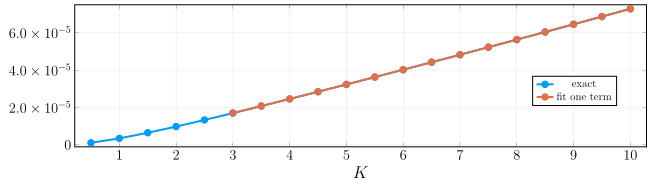

In [84]:
plot2 = plot(0.5:0.5:10,
               exact_extrap_ampl,
               label =  L"\textrm{exact}",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.80,0.75),
               size = (900, 300),
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               margin=5Plots.mm,
               legendfontsize=11,
               yguidefontsize=16,
               xguidefontsize=16,
               )

plot3 = plot!(3:0.5:10,
               [model_one_term(K,fit_one_term.param) for K in 3:0.5:10],
               label =  L"\textrm{fit one term}",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.8,0.50),
               xlabel = L"K",
               #yerror= error_Nmc100K,
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               grid=true,
               )

@show plot2

The fit quality has nothing to do with the Monte Carlo estimate. The fit we showed here is done using the exact amplitude. We can repeat it using the MonteCarlo amplitude to obtain very similar results.

In [46]:
fit_one_term = curve_fit(model_one_term, cutoffs[10:end], avg_ampl_extrapolation_Nmc100K[10:end], c0)
@show fit_one_term.param
@show margin_error(fit_one_term, 0.05); 

fit_one_term.param = [1.090353399086502, 6.1988042957978956e-6, -3.5044204014124314e-6]
margin_error(fit_one_term, 0.05) = [0.004772151486872148, 8.647607300568429e-8, 2.362802509961811e-7]


plot2 = Plot{Plots.PGFPlotsXBackend() n=2}


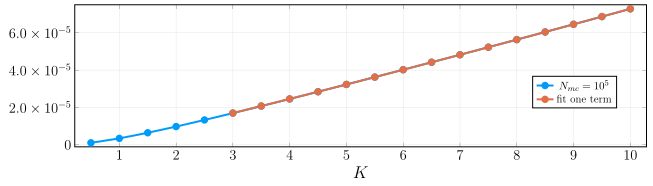

In [85]:
plot2 = plot(0.5:0.5:10,
               avg_ampl_extrapolation_Nmc100K,
               label =  L"N_{mc}=10^5",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.80,0.75),
               size = (900, 300),
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               margin=5Plots.mm,
               legendfontsize=11,
               yguidefontsize=16,
               xguidefontsize=16,
               )

plot3 = plot!(3:0.5:10,
               [model_one_term(K,fit_one_term.param) for K in 3:0.5:10],
               label =  L"\textrm{fit one term}",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.8,0.50),
               xlabel = L"K",
               #yerror= error_Nmc100K,
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               grid=true,
               )

@show plot2

## Changing face weights

As done for BF, let's now look at the amplitudes with modified face amplitude:

$$ A_f(j_f) = (2j_f+1) \to (2j_f+1)^\mu$$

using as possible values of $\mu=1/3$, $\mu=2/3$, $\mu=5/6$, $\mu=7/6$ and $\mu=4/3$.

In [16]:
function get_data_mu(Nmc,Dl,mu,trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(Nmc)/EPRL/immirzi_0.1/Dl_$(Dl)/weight_$(mu)/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

get_data_mu (generic function with 1 method)

### Fit the amplitude with $\mu=1/3$

In [17]:
layers_trials_DL10_mu_0333 = DataFrame()
for trial in 1:20
    layers_trials_DL10_mu_0333[!,"$(trial)"]=[get_data_mu(100000,10,0.333, trial).amp[id] - get_data_mu(100000,10,0.333, trial).amp[id-1] for id in 2:21]
end

layers_trials_DL9_mu_0333 = DataFrame()
for trial in 1:20
    layers_trials_DL9_mu_0333[!,"$(trial)"]=[get_data_mu(100000,9,0.333, trial).amp[id] - get_data_mu(100000,9,0.333, trial).amp[id-1] for id in 2:21]
end

layers_trials_DL8_mu_0333 = DataFrame()
for trial in 1:20
    layers_trials_DL8_mu_0333[!,"$(trial)"]=[get_data_mu(100000,8,0.333, trial).amp[id] - get_data_mu(100000,8,0.333, trial).amp[id-1] for id in 2:21]
end

# Extrapolate 

layers_trials_extrapolation_mu_0333 = DataFrame()
for trial in 1:20
    layers_trials_extrapolation_mu_0333[!,"$(trial)"]= extrapolate.(layers_trials_DL10_mu_0333[!,"$(trial)"],layers_trials_DL9_mu_0333[!,"$(trial)"],layers_trials_DL8_mu_0333[!,"$(trial)"])
end

layers_average_extrapolation_mu_0333 =  [mean(row) for row in eachrow(layers_trials_extrapolation_mu_0333)];
layers_variance_extrapolation_mu_0333 =  [var(row) for row in eachrow(layers_trials_extrapolation_mu_0333)];
amplitude_Nmc100K_extrapolation_mu_0333 = [sum(layers_average_extrapolation_mu_0333[1:id]) for id in 1:20];
error_Nmc100K_extrapolation_mu_0333 = sqrt.([sum(layers_variance_extrapolation_mu_0333[1:id]) for id in 1:20]);

In [18]:
fit_one_term = curve_fit(model_one_term, cutoffs[10:end], amplitude_Nmc100K_extrapolation_mu_0333[10:end], c0)
@show fit_one_term.param
@show margin_error(fit_one_term, 0.05); 

fit_one_term.param = [0.003664307684033266, 4.5819561958009975e-6, -3.847486706776899e-6]
margin_error(fit_one_term, 0.05) = [1.4292664975205918, 0.0018000574528284129, 0.0018001032600565895]


In [19]:
fit_two_terms = curve_fit(model_two_terms, cutoffs[10:end], amplitude_Nmc100K_extrapolation_mu_0333[10:end], c0)
@show fit_two_terms.param
@show margin_error(fit_two_terms, 0.05); 

fit_two_terms.param = [1.0590691416515714, -3.4979213064780123e-9, 7.090362256331711e-7]
margin_error(fit_two_terms, 0.05) = [0.006351204489339115, 5.525744844615539e-10, 4.536596781600986e-9]


plot2 = Plot{Plots.PGFPlotsXBackend() n=2}


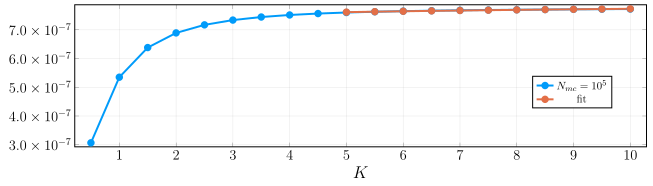

In [52]:
plot2 = plot(0.5:0.5:10,
               amplitude_Nmc100K_extrapolation_mu_0333,
               label =  L"N_{mc}=10^5",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.80,0.75),
               size = (900, 300),
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               margin=5Plots.mm,
               legendfontsize=11,
               yguidefontsize=16,
               xguidefontsize=16,
               )

plot3 = plot!(5:0.5:10,
               [model_one_term(K,fit_one_term.param) for K in 5:0.5:10],
               label =  L"\textrm{fit}",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.8,0.50),
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               grid=true,
               )

@show plot2

### Fit the amplitude with $\mu=2/3$

In [53]:
layers_trials_DL10_mu_0666 = DataFrame()
for trial in 1:20
    layers_trials_DL10_mu_0666[!,"$(trial)"]=[get_data_mu(100000,10,0.667, trial).amp[id] - get_data_mu(100000,10,0.667, trial).amp[id-1] for id in 2:21]
end

layers_trials_DL9_mu_0666 = DataFrame()
for trial in 1:20
    layers_trials_DL9_mu_0666[!,"$(trial)"]=[get_data_mu(100000,9,0.667, trial).amp[id] - get_data_mu(100000,9,0.667, trial).amp[id-1] for id in 2:21]
end

layers_trials_DL8_mu_0666 = DataFrame()
for trial in 1:20
    layers_trials_DL8_mu_0666[!,"$(trial)"]=[get_data_mu(100000,8,0.667, trial).amp[id] - get_data_mu(100000,8,0.667, trial).amp[id-1] for id in 2:21]
end

# Extrapolate 

layers_trials_extrapolation_mu_0666 = DataFrame()
for trial in 1:20
    layers_trials_extrapolation_mu_0666[!,"$(trial)"]= extrapolate.(layers_trials_DL10_mu_0666[!,"$(trial)"],layers_trials_DL9_mu_0666[!,"$(trial)"],layers_trials_DL8_mu_0666[!,"$(trial)"])
end

layers_average_extrapolation_mu_0666 =  [mean(row) for row in eachrow(layers_trials_extrapolation_mu_0666)];
layers_variance_extrapolation_mu_0666 =  [var(row) for row in eachrow(layers_trials_extrapolation_mu_0666)];
amplitude_Nmc100K_extrapolation_mu_0666 = [sum(layers_average_extrapolation_mu_0666[1:id]) for id in 1:20];
error_Nmc100K_extrapolation_mu_0666 = sqrt.([sum(layers_variance_extrapolation_mu_0666[1:id]) for id in 1:20]);

In [54]:
fit_one_term = curve_fit(model_one_term, cutoffs[10:end], amplitude_Nmc100K_extrapolation_mu_0666[10:end], c0)
@show fit_one_term.param
@show margin_error(fit_one_term, 0.05); 

fit_one_term.param = [0.016885277858055367, 5.552403581946038e-5, -5.373518020948588e-5]
margin_error(fit_one_term, 0.05) = [0.10411278638604474, 0.000353711334345921, 0.00035389936628288024]


In [55]:
fit_two_terms = curve_fit(model_two_terms, cutoffs[10:end], amplitude_Nmc100K_extrapolation_mu_0666[10:end], c0)
@show fit_two_terms.param
@show margin_error(fit_two_terms, 0.05); 

fit_two_terms.param = [1.3378832499203857, -1.8887147586144102e-8, 2.020517877775126e-6]
margin_error(fit_two_terms, 0.05) = [0.027722835025266408, 6.052971351178241e-9, 5.890218267946574e-8]


plot2 = Plot{Plots.PGFPlotsXBackend() n=2}


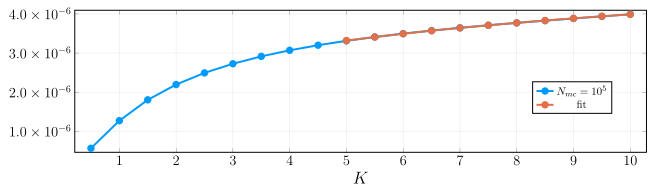

In [56]:
plot2 = plot(0.5:0.5:10,
               amplitude_Nmc100K_extrapolation_mu_0666,
               label =  L"N_{mc}=10^5",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.80,0.75),
               size = (900, 300),
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               margin=5Plots.mm,
               legendfontsize=11,
               yguidefontsize=16,
               xguidefontsize=16,
               )

plot3 = plot!(5:0.5:10,
               [model_one_term(K,fit_one_term.param) for K in 5:0.5:10],
               label =  L"\textrm{fit}",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.8,0.50),
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               grid=true,
               )

@show plot2

### Fit the amplitude with $\mu=5/6$

In [57]:
layers_trials_DL10_mu_0833 = DataFrame()
for trial in 1:20
    layers_trials_DL10_mu_0833[!,"$(trial)"]=[get_data_mu(100000,10,0.833, trial).amp[id] - get_data_mu(100000,10,0.833, trial).amp[id-1] for id in 2:21]
end

layers_trials_DL9_mu_0833 = DataFrame()
for trial in 1:20
    layers_trials_DL9_mu_0833[!,"$(trial)"]=[get_data_mu(100000,9,0.833, trial).amp[id] - get_data_mu(100000,9,0.833, trial).amp[id-1] for id in 2:21]
end

layers_trials_DL8_mu_0833 = DataFrame()
for trial in 1:20
    layers_trials_DL8_mu_0833[!,"$(trial)"]=[get_data_mu(100000,8,0.833, trial).amp[id] - get_data_mu(100000,8,0.833, trial).amp[id-1] for id in 2:21]
end

# Extrapolate 

layers_trials_extrapolation_mu_0833 = DataFrame()
for trial in 1:20
    layers_trials_extrapolation_mu_0833[!,"$(trial)"]= extrapolate.(layers_trials_DL10_mu_0833[!,"$(trial)"],layers_trials_DL9_mu_0833[!,"$(trial)"],layers_trials_DL8_mu_0833[!,"$(trial)"])
end

layers_average_extrapolation_mu_0833 =  [mean(row) for row in eachrow(layers_trials_extrapolation_mu_0833)];
layers_variance_extrapolation_mu_0833 =  [var(row) for row in eachrow(layers_trials_extrapolation_mu_0833)];
amplitude_Nmc100K_extrapolation_mu_0833 = [sum(layers_average_extrapolation_mu_0833[1:id]) for id in 1:20];
error_Nmc100K_extrapolation_mu_0833 = sqrt.([sum(layers_variance_extrapolation_mu_0833[1:id]) for id in 1:20]);

In [58]:
fit_one_term = curve_fit(model_one_term, cutoffs[10:end], amplitude_Nmc100K_extrapolation_mu_0833[10:end], c0)
@show fit_one_term.param
@show margin_error(fit_one_term, 0.05); 

fit_one_term.param = [0.876256576813937, 1.645014807627496e-6, 2.629854659464015e-6]
margin_error(fit_one_term, 0.05) = [0.11636968135611049, 6.009840275398431e-7, 1.2392132256248087e-6]


In [59]:
fit_two_terms = curve_fit(model_two_terms, cutoffs[10:end], amplitude_Nmc100K_extrapolation_mu_0833[10:end], c0)
@show fit_two_terms.param
@show margin_error(fit_two_terms, 0.05); 

fit_two_terms.param = [1.5196175863440498, 9.536553222266993e-8, 3.582151613254366e-6]
margin_error(fit_two_terms, 0.05) = [0.1079744812993946, 8.318426901968186e-8, 3.065808338301674e-7]


plot2 = Plot{Plots.PGFPlotsXBackend() n=2}


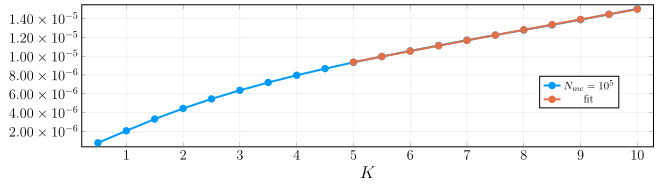

In [60]:
plot2 = plot(0.5:0.5:10,
               amplitude_Nmc100K_extrapolation_mu_0833,
               label =  L"N_{mc}=10^5",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.80,0.75),
               size = (900, 300),
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               margin=5Plots.mm,
               legendfontsize=11,
               yguidefontsize=16,
               xguidefontsize=16,
               )

plot3 = plot!(5:0.5:10,
               [model_one_term(K,fit_one_term.param) for K in 5:0.5:10],
               label =  L"\textrm{fit}",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.8,0.50),
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               grid=true,
               )

@show plot2

### Fit the amplitude with $\mu=7/6$

In [61]:
layers_trials_DL10_mu_1167 = DataFrame()
for trial in 1:20
    layers_trials_DL10_mu_1167[!,"$(trial)"]=[get_data_mu(100000,10,1.167, trial).amp[id] - get_data_mu(100000,10,1.167, trial).amp[id-1] for id in 2:21]
end

layers_trials_DL9_mu_1167 = DataFrame()
for trial in 1:20
    layers_trials_DL9_mu_1167[!,"$(trial)"]=[get_data_mu(100000,9,1.167, trial).amp[id] - get_data_mu(100000,9,1.167, trial).amp[id-1] for id in 2:21]
end

layers_trials_DL8_mu_1167 = DataFrame()
for trial in 1:20
    layers_trials_DL8_mu_1167[!,"$(trial)"]=[get_data_mu(100000,8,1.167, trial).amp[id] - get_data_mu(100000,8,1.167, trial).amp[id-1] for id in 2:21]
end

# Extrapolate 

layers_trials_extrapolation_mu_1167 = DataFrame()
for trial in 1:20
    layers_trials_extrapolation_mu_1167[!,"$(trial)"]= extrapolate.(layers_trials_DL10_mu_1167[!,"$(trial)"],layers_trials_DL9_mu_1167[!,"$(trial)"],layers_trials_DL8_mu_1167[!,"$(trial)"])
end

layers_average_extrapolation_mu_1167 =  [mean(row) for row in eachrow(layers_trials_extrapolation_mu_1167)];
layers_variance_extrapolation_mu_1167 =  [var(row) for row in eachrow(layers_trials_extrapolation_mu_1167)];
amplitude_Nmc100K_extrapolation_mu_1167 = [sum(layers_average_extrapolation_mu_1167[1:id]) for id in 1:20];
error_Nmc100K_extrapolation_mu_1167 = sqrt.([sum(layers_variance_extrapolation_mu_1167[1:id]) for id in 1:20]);

In [62]:
fit_one_term = curve_fit(model_one_term, cutoffs[10:end], amplitude_Nmc100K_extrapolation_mu_1167[10:end], c0)
@show fit_one_term.param
@show margin_error(fit_one_term, 0.05); 

fit_one_term.param = [2.845046815013597, 8.171062307853707e-7, 6.335508177456217e-5]
margin_error(fit_one_term, 0.05) = [0.18160356110275855, 3.5862543662124026e-7, 1.6458030227447702e-5]


In [63]:
fit_two_terms = curve_fit(model_two_terms, cutoffs[10:end], amplitude_Nmc100K_extrapolation_mu_1167[10:end], c0)
@show fit_two_terms.param
@show margin_error(fit_two_terms, 0.05); 

fit_two_terms.param = [2.7875903912386146, 5.798740368377402e-7, 4.425670887106028e-6]
margin_error(fit_two_terms, 0.05) = [29.059399528290196, 6.815491481038182e-5, 2.6693920260066288e-6]


plot2 = Plot{Plots.PGFPlotsXBackend() n=2}


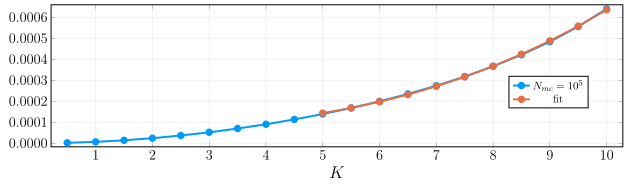

In [64]:
plot2 = plot(0.5:0.5:10,
               amplitude_Nmc100K_extrapolation_mu_1167,
               label =  L"N_{mc}=10^5",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.80,0.75),
               size = (900, 300),
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               margin=5Plots.mm,
               legendfontsize=11,
               yguidefontsize=16,
               xguidefontsize=16,
               )

plot3 = plot!(5:0.5:10,
               [model_one_term(K,fit_one_term.param) for K in 5:0.5:10],
               label =  L"\textrm{fit}",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.8,0.50),
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               grid=true,
               )

@show plot2

### Fit the amplitude with $\mu=4/3$

In [20]:
layers_trials_DL10_mu_1333 = DataFrame()
for trial in 1:20
    layers_trials_DL10_mu_1333[!,"$(trial)"]=[get_data_mu(100000,10,1.333, trial).amp[id] - get_data_mu(100000,10,1.333, trial).amp[id-1] for id in 2:21]
end

layers_trials_DL9_mu_1333 = DataFrame()
for trial in 1:20
    layers_trials_DL9_mu_1333[!,"$(trial)"]=[get_data_mu(100000,9,1.333, trial).amp[id] - get_data_mu(100000,9,1.333, trial).amp[id-1] for id in 2:21]
end

layers_trials_DL8_mu_1333 = DataFrame()
for trial in 1:20
    layers_trials_DL8_mu_1333[!,"$(trial)"]=[get_data_mu(100000,8,1.333, trial).amp[id] - get_data_mu(100000,8,1.333, trial).amp[id-1] for id in 2:21]
end

# Extrapolate 

layers_trials_extrapolation_mu_1333 = DataFrame()
for trial in 1:20
    layers_trials_extrapolation_mu_1333[!,"$(trial)"]= extrapolate.(layers_trials_DL10_mu_1333[!,"$(trial)"],layers_trials_DL9_mu_1333[!,"$(trial)"],layers_trials_DL8_mu_1333[!,"$(trial)"])
end

layers_average_extrapolation_mu_1333 =  [mean(row) for row in eachrow(layers_trials_extrapolation_mu_1333)];
layers_variance_extrapolation_mu_1333 =  [var(row) for row in eachrow(layers_trials_extrapolation_mu_1333)];
amplitude_Nmc100K_extrapolation_mu_1333 = [sum(layers_average_extrapolation_mu_1333[1:id]) for id in 1:20];
error_Nmc100K_extrapolation_mu_1333 = sqrt.([sum(layers_variance_extrapolation_mu_1333[1:id]) for id in 1:20]);

In [66]:
fit_one_term = curve_fit(model_one_term, cutoffs[10:end], amplitude_Nmc100K_extrapolation_mu_1333[10:end], c0)
@show fit_one_term.param
@show margin_error(fit_one_term, 0.05); 

fit_one_term.param = [3.8988028757965476, 6.89369391352593e-7, 0.0003583208443364084]
margin_error(fit_one_term, 0.05) = [0.22317879380836797, 3.6179678122287305e-7, 0.00011493784954958347]


In [67]:
fit_two_terms = curve_fit(model_two_terms, cutoffs[10:end], amplitude_Nmc100K_extrapolation_mu_1333[10:end], c0)
@show fit_two_terms.param
@show margin_error(fit_two_terms, 0.05); 

fit_two_terms.param = [3.823347793491848, 4.840561596919496e-7, 3.7767585269873356e-6]
margin_error(fit_two_terms, 0.05) = [51.98281684249289, 0.0001022935676657538, 8.544463614080162e-6]


plot2 = Plot{Plots.PGFPlotsXBackend() n=2}


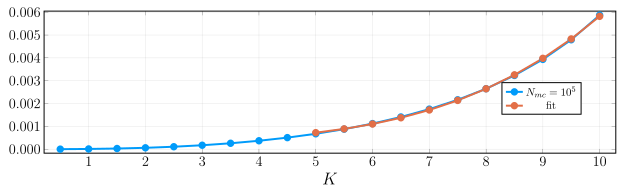

In [68]:
plot2 = plot(0.5:0.5:10,
               amplitude_Nmc100K_extrapolation_mu_1333,
               label =  L"N_{mc}=10^5",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.80,0.75),
               size = (900, 300),
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               margin=5Plots.mm,
               legendfontsize=11,
               yguidefontsize=16,
               xguidefontsize=16,
               )

plot3 = plot!(5:0.5:10,
               [model_one_term(K,fit_one_term.param) for K in 5:0.5:10],
               label =  L"\textrm{fit}",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.8,0.50),
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               grid=true,
               )

@show plot2

### Extrap test

In [31]:
function make_lambda(data)
    (data[3:end] .- data[2:end-1]) ./ (data[2:end-1] .- data[1:end-2])
end

make_lambda (generic function with 1 method)

In [35]:
data_10_shell = zeros(20, 11);

for Dl_index = 1:11

layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data_mu(100000,Dl_index-1,1.167,trial).amp[id] - get_data_mu(100000,Dl_index-1,1.167,trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc100K = [sum(layers_average[1:id]) for id in 1:20];
    
data_10_shell[:, Dl_index] .= amplitude_Nmc100K[:]
    
end

In [36]:
lambda20 = make_lambda(data_10_shell[20,:]);
lambda15 = make_lambda(data_10_shell[15,:]);
lambda10 = make_lambda(data_10_shell[10,:]);

plotib0 = Plot{Plots.PGFPlotsXBackend() n=3}


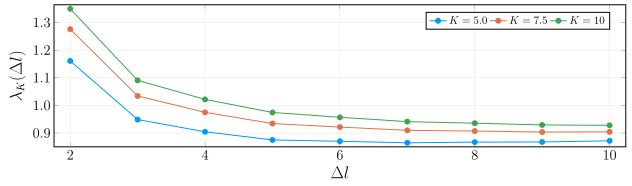

In [37]:
plotib0 = plot(
    2.0:10.0,
    [   lambda10,
        lambda15,
        lambda20,
    ],
    label = [ L"K=5.0" L"K=7.5" L"K=10"],
    xlabel = L"\Delta l",
    ylabel = L"\lambda_K(\Delta l)",
    markershape = [:circle :circle :circle],
    shape = [:circle :circle :circle],
    xticks = 0:2:20,
    #ylim = (0.8, 1.20),
    size = (900, 300),
    legend = (0.65, 0.95),
    legend_column = -1,
    legendfontsize=11,
    yguidefontsize=16,
    xguidefontsize=16,
)

@show plotib0

As expected, changing $\mu$ does not change the convergence in $\Delta l$

## Imposing exponent

Based on what has been computed in BF, let's assume that the amplitude behaves asymptotically (at the leading order) as:

$$ W \sim K^{6 \mu + p} $$

Let's now try to fit the data by *imposing* the exponent of the cutoff. Let's assume that $p \approx -4.2$

### $\mu = 1$

In [236]:
@. model_1(K, c) = c[1] * K^(6 - 4.2) + c[2]
#@. model_2(K, c) = c[1] * K^2 + c[2]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [4.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 5 to 10 with steps of 1/2
fit_1 = curve_fit(model_1, cutoffs[10:end], avg_ampl_extrapolation_Nmc100K[10:end], c0)
@show fit_1.param
@show margin_error(fit_1, 0.05); 
#println("\n")
#fit_2 = curve_fit(model_2, cutoffs[10:end], avg_ampl_extrapolation_Nmc100K[10:end], c0)
#@show fit_2.param
#@show margin_error(fit_2, 0.05);     

fit_1.param = [8.951970775595922e-7, 1.766136180898136e-5]
margin_error(fit_1, 0.05) = [4.467513916665573e-8, 1.8469135950624623e-6]


plot1 = Plot{Plots.PGFPlotsXBackend() n=2}


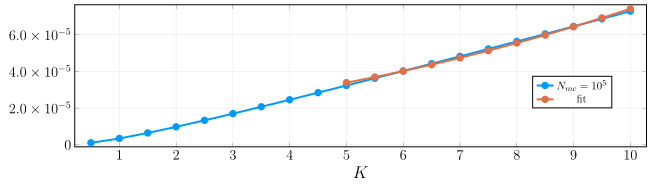

In [237]:
plot1 = plot(0.5:0.5:10,
               avg_ampl_extrapolation_Nmc100K,
               label =  L"N_{mc}=10^5",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.80,0.75),
               size = (900, 300),
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               margin=5Plots.mm,
               legendfontsize=11,
               yguidefontsize=16,
               xguidefontsize=16,
               )

plot!(5:0.5:10,
               [model_1(K,fit_1.param) for K in 5:0.5:10],
               label =  L"\textrm{fit}",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.8,0.50),
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               grid=true,
               )

@show plot1

## $\mu = 7/6 $

In [232]:
@. model_1(K, c) = c[1] * K^(7 - 4.2) + c[2]
#@. model_2(K, c) = c[1] * K^3 + c[2]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [2.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 5 to 10 with steps of 1/2
fit_1 = curve_fit(model_1, cutoffs[10:end], amplitude_Nmc100K_extrapolation_mu_1167[10:end], c0)
@show fit_1.param
@show margin_error(fit_1, 0.05); 
#println("\n")
#fit_2 = curve_fit(model_2, cutoffs[10:end], amplitude_Nmc100K_extrapolation_mu_1167[10:end], c0)
#@show fit_2.param
#@show margin_error(fit_2, 0.05);

fit_1.param = [9.111052937020587e-7, 5.940238961109813e-5]
margin_error(fit_1, 0.05) = [1.3287608767989788e-8, 4.750554489570177e-6]


plot2 = Plot{Plots.PGFPlotsXBackend() n=2}


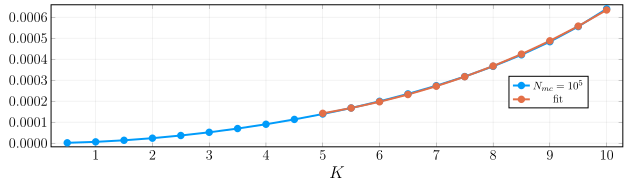

In [233]:
plot2 = plot(0.5:0.5:10,
               amplitude_Nmc100K_extrapolation_mu_1167,
               label =  L"N_{mc}=10^5",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.80,0.75),
               size = (900, 300),
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               margin=5Plots.mm,
               legendfontsize=11,
               yguidefontsize=16,
               xguidefontsize=16,
               )

plot!(5:0.5:10,
               [model_1(K,fit_1.param) for K in 5:0.5:10],
               label =  L"\textrm{fit}",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.8,0.50),
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               grid=true,
               )

@show plot2

## $\mu = 4/3 $

In [234]:
@. model_1(K, c) = c[1] * K^(8-4.2) + c[2]
#@. model_2(K, c) = c[1] * K^4 + c[2]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [2.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 5 to 10 with steps of 1/2
fit_1 = curve_fit(model_1, cutoffs[10:end], amplitude_Nmc100K_extrapolation_mu_1333[10:end], c0)
@show fit_1.param
@show margin_error(fit_1, 0.05); 
#println("\n")
#fit_2 = curve_fit(model_2, cutoffs[10:end], amplitude_Nmc100K_extrapolation_mu_1333[10:end], c0)
#@show fit_2.param
#@show margin_error(fit_2, 0.05);

fit_1.param = [8.697111672589097e-7, 0.00031089319556793264]
margin_error(fit_1, 0.05) = [1.4837609357357294e-8, 4.7681881398654325e-5]


plot2 = Plot{Plots.PGFPlotsXBackend() n=2}


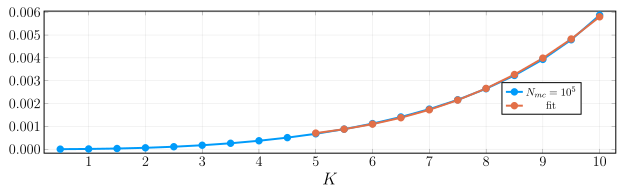

In [235]:
plot2 = plot(0.5:0.5:10,
               amplitude_Nmc100K_extrapolation_mu_1333,
               label =  L"N_{mc}=10^5",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.80,0.75),
               size = (900, 300),
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               margin=5Plots.mm,
               legendfontsize=11,
               yguidefontsize=16,
               xguidefontsize=16,
               )

plot!(5:0.5:10,
               [model_1(K,fit_1.param) for K in 5:0.5:10],
               label =  L"\textrm{fit}",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.8,0.50),
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               grid=true,
               )

@show plot2

Changing $\mu$ in EPRL seems to suggest that the divergence is closer to quadratic one rather than a linear one.